## Single Shot Detector for ExtremeWeather Data

### Preprocessing the Data
The [ExtremeWeather](https://extremeweatherdataset.github.io/) data set consists of weather data for a specific 25km region from 1979 to 2005. 
The data is organized by year and contains 4 images per day. Each image has 768x1152 pixels across 16 channels for different weather variables. 
In addition, each day has up to 15 bounding boxes
surrounding extreme weather events classified as Tropical Depression, Tropical Cyclone, Extratropical Cyclone, and Atmospheric River.

The goal is to correctly identify and classify extreme weather events. 
The first challenge is the sheer size of the data set.
Each year, even when compressed, takes 64 GB to store.
As the "small" data set, we consider training on 1979 and 1981 then testing on 1984.
We preprocess each year by considering only the month of July and rescaling each image so its of size 300x300.
In addition, we choose 3 of the 16 channels by hand for 'visual explainability' of bounding boxes.
All together, we are able to reduce the size of the compressed data from 64 GB to 40 MB consisting of 124 300x300 images and bounding boxes.




### Set up

In [51]:
## Set up
### Loading Data
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

### Model
import numpy as np
import torch
import gc

### Visualization
from matplotlib import patches
import matplotlib.pyplot as plt

### Store data in drive
from google.colab import drive
drive.mount('/content/drive')

#### Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the Data

In [88]:
# Modified from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class ExtremeWeatherDataset(Dataset):
  def __init__(self, bbox_file, img_dir):
    self.bboxes = []
    with open(bbox_file, 'r') as f:
      for line in f:
        self.bboxes += [torch.tensor(eval(line))]
    self.img_dir = img_dir

  def __len__(self):
    return len(self.bboxes)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, str(idx)+'.txt')
    image = read_image(img_path)
    #with open(img_path, 'r') as f:
    #  lines = f.readlines()
    #  assert len(lines) == 1
    #  image = torch.tensor(eval(lines[0]))
    bbox = self.bboxes[idx]
    return image, bbox

In [86]:
prefix = '/content/drive/My Drive/extremeweather/' # where the data is stored
train_data = ExtremeWeatherDataset(bbox_file=prefix+'train/bboxes.txt', img_dir=prefix+'train')
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

### Visualizing Images

In [83]:
EVENTS = ['Tropical Depression', 'Tropical Cyclone', 'Extratropical Cyclone', 'Atmospheric River']
NAMES = ['Sea Level Pressure', 'Total Water', 'Lowest Zonal Wind']
COLORS = ['red', 'blue', 'white', 'black']

def plot_image(image, box):
  plt.rcParams.update({'font.size': 7})
  if len(image.shape) == 2: image = np.array([image])
  num_channels = image.shape[0]
  num_rows = int(np.sqrt(num_channels))
  num_cols = int(np.round(num_channels//num_rows))
  fig, axs = plt.subplots(num_rows,num_cols, figsize=(15,15)) 
  fig.tight_layout()
  for i in range(num_rows):
    for j in range(num_cols):
      channel = i*num_cols + j 
      if channel < image.shape[0]:
        if num_channels == 1: ax = axs
        elif num_rows == 1: ax = axs[j]
        elif num_rows > 1: ax = axs[i,j]
        ax.axis('off')
        ax.imshow(image[channel,]) 
        addbox(ax, box)
        ax.set_title(NAMES[channel])
  plt.legend()
  plt.show()
    
def addbox(ax, box):
  for row in box:
    row = row.tolist()
    if not np.all(row == -1):
      ymin, xmin, ymax, xmax, event_class = row
      handles, labels = ax.get_legend_handles_labels()
      label = "" if EVENTS[event_class] in labels else EVENTS[event_class]
      ax.add_patch(patches.Rectangle(xy=(xmin, ymin), width=xmax-xmin,
                                     height=ymax-ymin, fill=False,
                                     label=label, color=COLORS[event_class]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



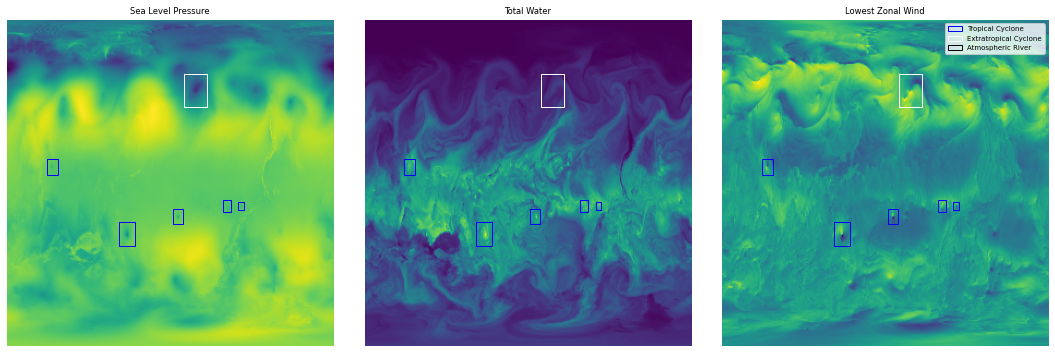

In [89]:
# Plot images
images, bboxes = next(iter(train_dataloader))
plot_image(images[0], bboxes[0])

### Training the SSD Model
Instead of building the SSD model from scratch, we use a pretrained model on the COCO database. 

In [ ]:
gc.collect()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

In [ ]:
from preprocess import read_data
year = '1979'
images, boxes = read_data(year)